In [1]:
import pandas as pd
# import glob
# from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
import joblib
from tabulate import tabulate

# data science libraries
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold 
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# custom modules
from package import my_modules

In [2]:
rng = np.random.RandomState(42)
nthread=4

In [3]:
# read the median datasets
X_train_cleaned_median, X_test_cleaned_median, X_holdout_cleaned_median,y_train, y_test, y_holdout = joblib.load("../out_files/cleaned_splits/split_data_cleaned_median.joblib")

In [4]:
# Define the scoring metric 
ftwo_score = make_scorer(fbeta_score, beta=2)

In [5]:
def feature_eng_1(df_in) -> pd.DataFrame:
    """
    Feature engineering round I
    - Drop NISysABP and NIDiasABP and retain just NIMAP
    - Convert to AST/ALT and PaCO2/HC03 (after replacing NaN with 1 to avoid division by NaN issue)
    - Replace NaN in TroponinI, Cholesterol & TroponinT to 0
    """
    selected_columns_drop = ['median_NISysABP', 'median_NIDiasABP']
    selected_columns = ['median_TroponinI','median_Cholesterol','median_TroponinT']
    selected_columns_ratio = ['median_AST', 'median_ALT', 'median_PaCO2', 'median_HCO3']
    
    # drop selected columns
    df = df_in.drop(columns=selected_columns_drop)

    # Fill NaN with 0
    df[selected_columns] = df[selected_columns].fillna(0)

    # Fill NaN values with 1 in the selected columns
    df[selected_columns_ratio] = df[selected_columns_ratio].fillna(1)
    # get ratio & drop original columns
    df['AST/ALT'] = df['median_AST']/df['median_ALT']
    df['PaCO2/HC03'] = df['median_PaCO2']/df['median_HCO3']
    df = df.drop(columns=selected_columns_ratio)
    
    # # introduce random features
    # df['Binary_random'] = np.random.randint(0, 2, size=len(df))
    # df['Uniform_random_1'] = np.random.randint(0, 101, size=len(df))/100
    # # max_val = df.values.max(skipna=True)
    # # df['Uniform_random_2'] = np.random.randint(0, max_val, size=len(df))

    return df.copy()

In [6]:
my_modules.get_df_head_tail_shape(X_train_cleaned_median)
X_train_median_fe1 = feature_eng_1(X_train_cleaned_median)
X_test_median_fe1 = feature_eng_1(X_test_cleaned_median)
X_holdout_median_fe1=feature_eng_1(X_holdout_cleaned_median)


DataFrame Shape:
(2400, 43)

DataFrame Head:
+------------+------------+------------+----------------+------------+------------------+--------------------+-------------------+----------------+-------------+------------+----------------+-------------+--------------------+-----------+----------+----------------+------------+-----------+------------------+-------------------+-----------------+-----------+--------------+-------------+------------------+-----------------+-------------+---------------+-------------+------------------+------------------+--------------+------------+-----------+----------+------+--------+-------------------+-------------+-------------+-------------+-------------+
| median_ALP | median_ALT | median_AST | median_Albumin | median_BUN | median_Bilirubin | median_Cholesterol | median_Creatinine | median_DiasABP | median_FiO2 | median_GCS | median_Glucose | median_HCO3 |     median_HCT     | median_HR | median_K | median_Lactate | median_MAP | median_Mg | median_NID

In [7]:
my_modules.get_df_head_tail_shape(X_train_median_fe1)
my_modules.get_df_head_tail_shape(X_test_median_fe1)
my_modules.get_df_head_tail_shape(X_holdout_median_fe1)



DataFrame Shape:
(2400, 39)

DataFrame Head:
+------------+----------------+------------+------------------+--------------------+-------------------+----------------+-------------+------------+----------------+--------------------+-----------+----------+----------------+------------+-----------+-------------------+-----------+-------------+------------------+-----------------+-------------+---------------+-------------+------------------+------------------+--------------+------------+-----------+----------+------+--------+-------------------+-------------+-------------+-------------+-------------+-------------------+----------------------+
| median_ALP | median_Albumin | median_BUN | median_Bilirubin | median_Cholesterol | median_Creatinine | median_DiasABP | median_FiO2 | median_GCS | median_Glucose |     median_HCT     | median_HR | median_K | median_Lactate | median_MAP | median_Mg |   median_NIMAP    | median_Na | median_PaO2 | median_Platelets | median_RespRate | median_SaO2 | me

In [8]:
# save the split datasets for baseline model 
joblib.dump((X_train_median_fe1, X_test_median_fe1, X_holdout_median_fe1,y_train, y_test, y_holdout), "../out_files/cleaned_splits/split_data_cleaned_median_fe1.joblib")

['../out_files/cleaned_splits/split_data_cleaned_median_fe1.joblib']

Training logistic_regression model...


Pipeline(steps=[('imputer', KNNImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    random_state=RandomState(MT19937) at 0x786DB01B9A40,
                                    solver='liblinear'))])

Calculating PR AUC...
Model PR AUC: 0.54


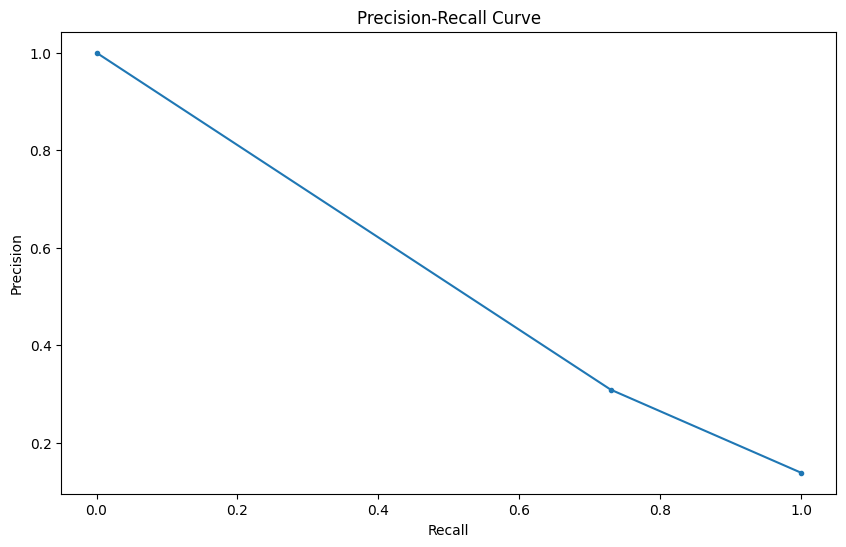

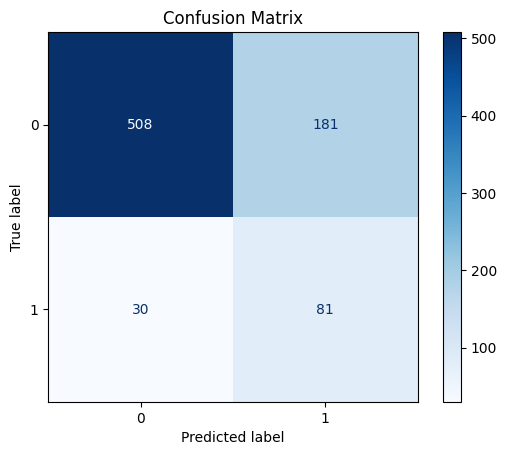

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       689
           1       0.31      0.73      0.43       111

    accuracy                           0.74       800
   macro avg       0.63      0.73      0.63       800
weighted avg       0.86      0.74      0.77       800



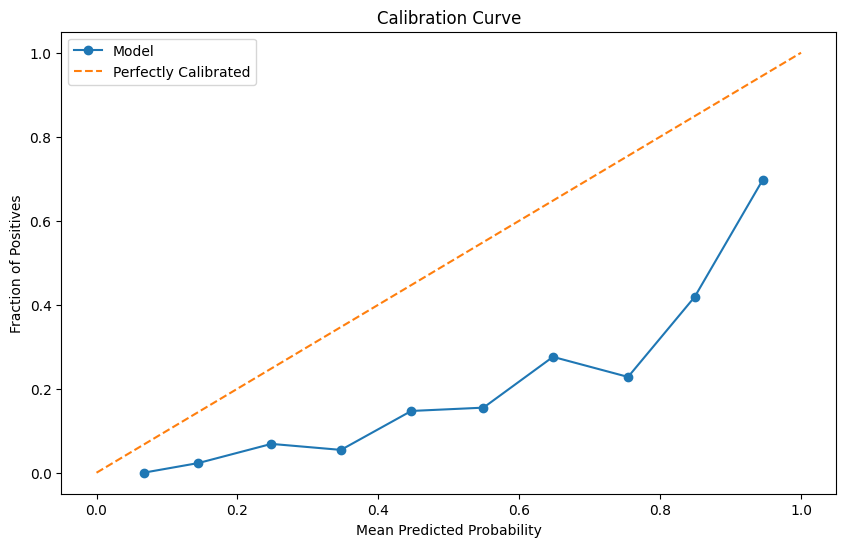

logistic_regression model does not have feature importances.
Training random_forest model...


Pipeline(steps=[('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=RandomState(MT19937) at 0x786DB01B9A40))])

Calculating PR AUC...
Model PR AUC: 0.49


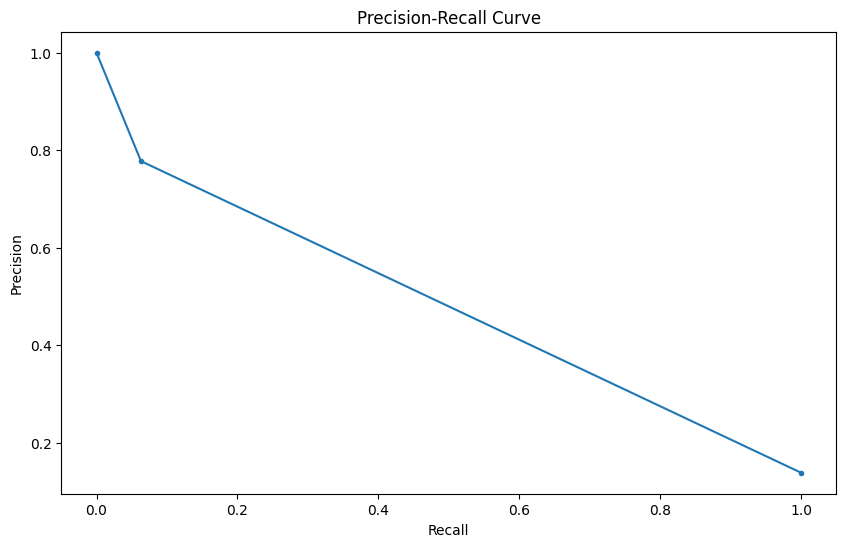

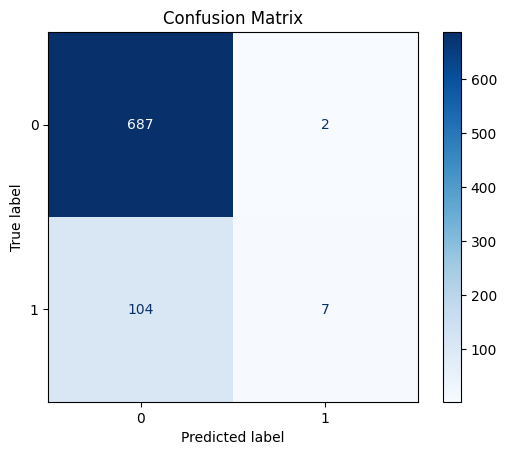

Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       689
           1       0.78      0.06      0.12       111

    accuracy                           0.87       800
   macro avg       0.82      0.53      0.52       800
weighted avg       0.86      0.87      0.82       800



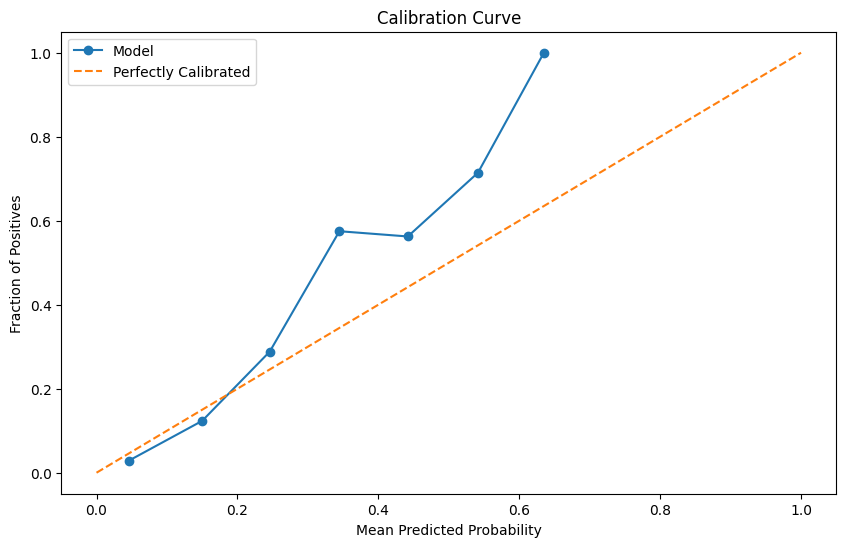

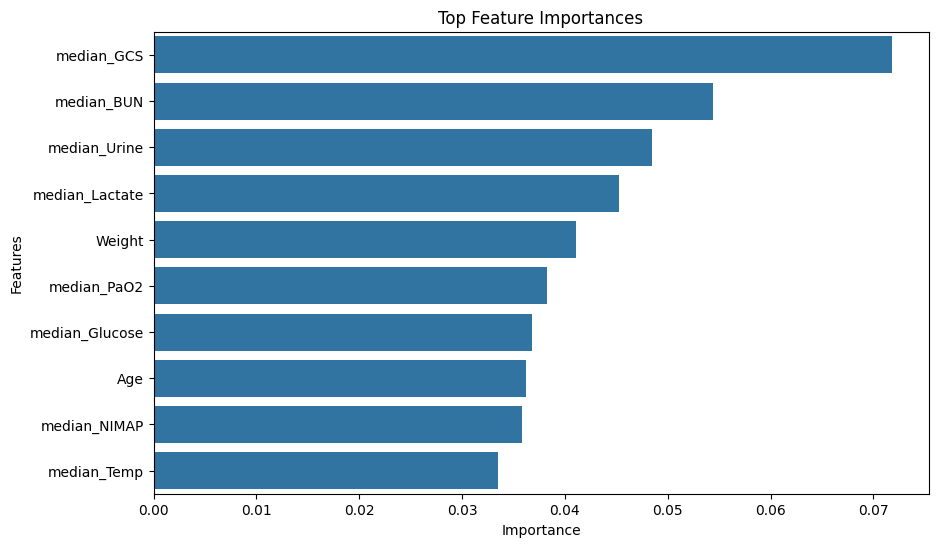

Training xgboost model...


Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, nthread=4, ...))])

Calculating PR AUC...
Model PR AUC: 0.44


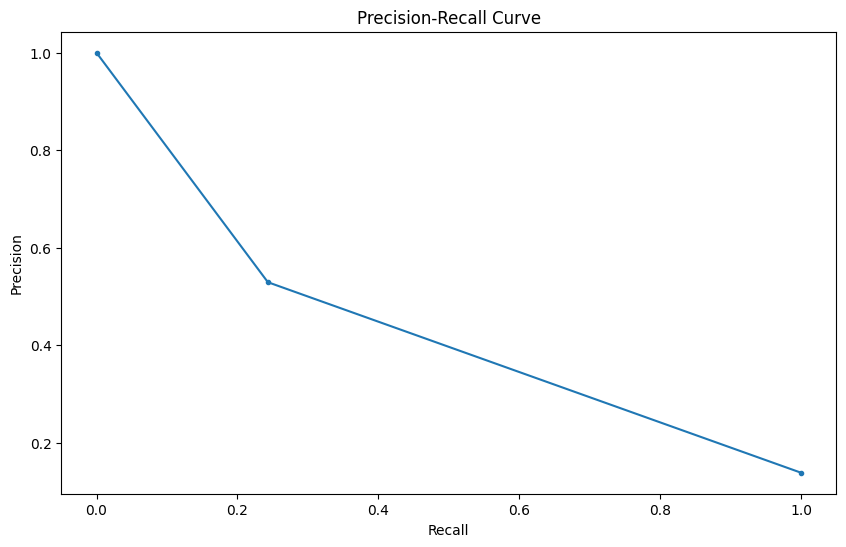

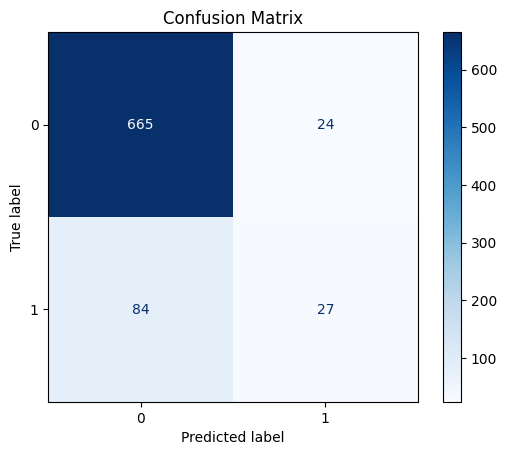

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       689
           1       0.53      0.24      0.33       111

    accuracy                           0.86       800
   macro avg       0.71      0.60      0.63       800
weighted avg       0.84      0.86      0.84       800



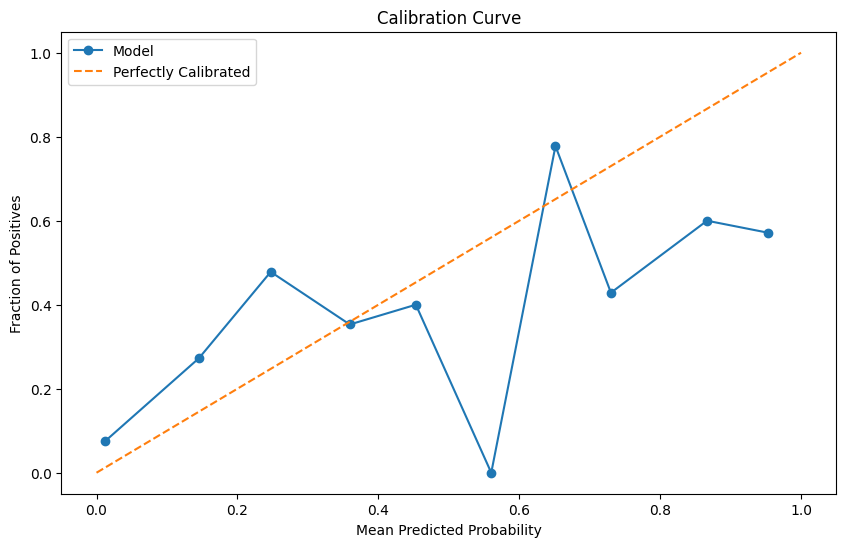

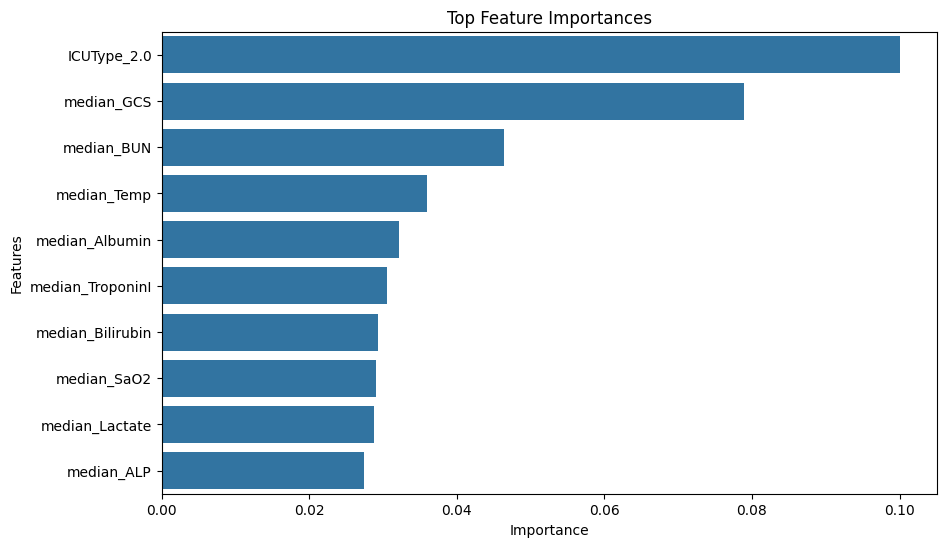

In [9]:
# run logistic regression, random forest and xgboost

model_factory = {
    'logistic_regression': Pipeline([
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(solver='liblinear', random_state=rng, class_weight='balanced'))
    ]),
    'random_forest': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced')) 
    ]),
    'xgboost': Pipeline([
        # ('imputer', KNNImputer(n_neighbors=5)),
        # ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(random_state=rng, scorer= ftwo_score, nthread=nthread))
    ])
}


for model_name, model in model_factory.items():
    print(f"Training {model_name} model...")
    model.fit(X_train_median_fe1, y_train)
    my_modules.evaluate_model(model, X_test_median_fe1, y_test)
    # plot feature importances
    if hasattr(model.named_steps['classifier'], 'feature_importances_'):
        feature_importances = my_modules.get_feature_importances(model.named_steps['classifier'], X_train_median_fe1, y_train)
        n_features_to_plot = min(10, len(feature_importances))
        my_modules.plot_feature_importances(feature_importances, n=n_features_to_plot)
    else:
        print(f"{model_name} model does not have feature importances.")   
        

- Random forest model showed minor improvement but we are not there yet
- Lets check if dimensionality reduction before Random forest provides any value (since we tackled the highly correlated features through feature engineering already, odds are low, but getting the method down for future use)

GridSearchCV(estimator=Pipeline(memory='/tmp/tmpfgegrwuw',
                                steps=[('impute', KNNImputer()),
                                       ('pca', PCA(iterated_power=7)),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=RandomState(MT19937) at 0x786DB01B9A40))]),
             n_jobs=6,
             param_grid=[{'pca__n_components': [3, 4, 8, 10, 12, 15]}],
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

Best parameter (CV score=%0.2f):0.05808020129664052
Best parameters: {'pca__n_components': 4}


<Figure size 800x600 with 0 Axes>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Principal Component Number')

Text(0, 0.5, 'Explained Variance Ratio')

Text(0.5, 1.0, 'Explained Variance Spectrum')

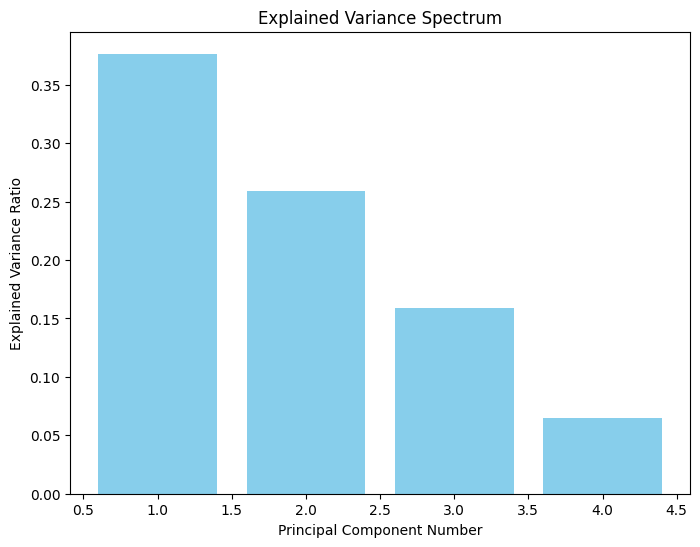

<Figure size 1000x1000 with 0 Axes>

Text(0.5, 1.0, 'Cumulative Explained Variance as a Function of the Number of Components')

Text(0, 0.5, 'Cumulative Explained variance')

Text(0.5, 0, 'Principal components')

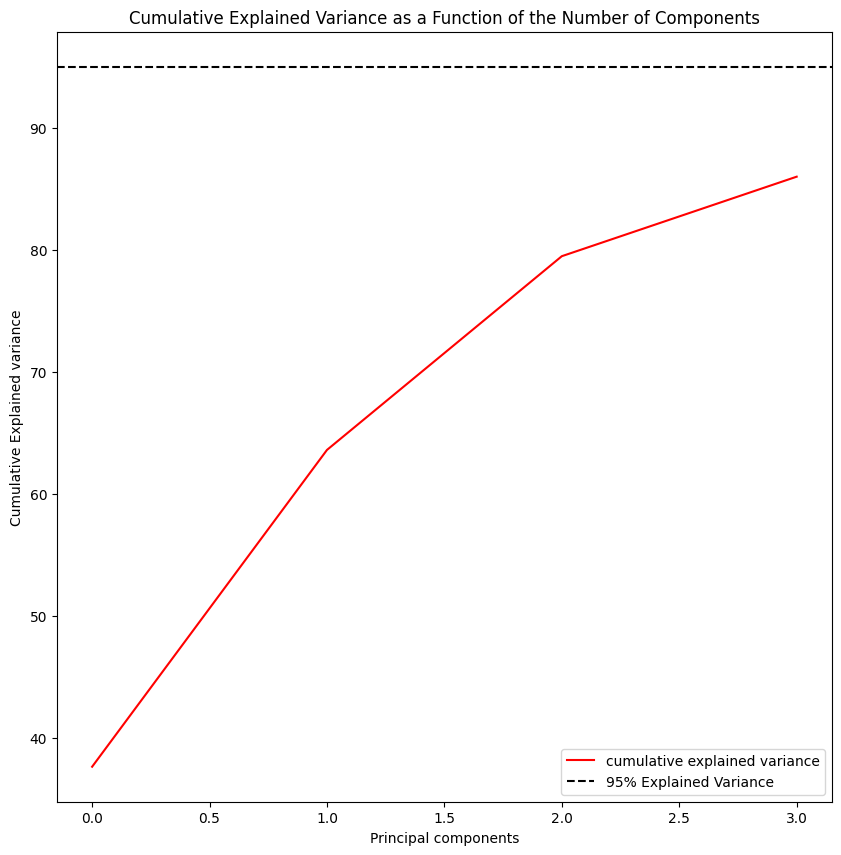

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from tempfile import mkdtemp

# ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced')) 
cache_dir = mkdtemp()
cached_pipeline = Pipeline(
    [
        ("impute", KNNImputer()), # pca can't handle NaN
        ("pca",PCA(iterated_power=7)), 
        ('classifier', RandomForestClassifier(random_state=rng, class_weight='balanced'))
    ], memory=cache_dir)

N_FEATURES_OPTIONS = [3, 4, 8, 10, 12,15]
# C_OPTIONS = [1, 10, 100, 1000]

param_grid = [
    {
        "pca__n_components": N_FEATURES_OPTIONS,
        # "classify__C": C_OPTIONS,
    },
    # {
    #     "reduce_dim": [SelectKBest(mutual_info_classif)],
    #     "reduce_dim__k": N_FEATURES_OPTIONS,
    #     # "classify__C": C_OPTIONS,
    # },
]
reducer_labels = ["PCA"] # ,  "KBest(mutual_info_classif)"

grid_search = GridSearchCV(cached_pipeline, n_jobs=6, param_grid=param_grid, scoring=ftwo_score)
grid_search.fit(X_train_median_fe1, y_train)

print(f"Best parameter (CV score=%0.2f):{grid_search.best_score_}")
print(f"Best parameters: {grid_search.best_params_}")

# Get the best estimator
best_pca = grid_search.best_estimator_.named_steps['pca']

# Extract explained variance ratio
explained_variance_ratio = best_pca.explained_variance_ratio_

# Plot the spectrum
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Spectrum')
plt.show()

cumulative_sum = np.cumsum(explained_variance_ratio)*100
d = [n for n in range(len(cumulative_sum))]

plt.figure(figsize=(10, 10))
plt.plot(d,cumulative_sum, color = 'red',label='cumulative explained variance')
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
plt.legend(loc='best')
plt.show()


In [11]:

# plt.plot(np.arange(1,len(search.)))